## Experiments on the MNIST dataset

The goal of this notebook is to train  several classifiers on the classical MNIST database. This database is very popular in the machine learning community as a first test for new algorithms. This dataset is quite simple and artificial : having good results on MNIST does not mean that your algorithm is good, but having bad results surely means that you have to improve your algorithm. 


<img src="https://kermorvant.github.io/ml/dataiku/images/MnistExamples.png">



You can find reference results on the MNIST dataset [here](http://yann.lecun.com/exdb/mnist/).

### Libraries 

We will use the following libraries : 
* sklearn (scikit-learn) for machine learning algorithms
* pandas for manipulating data
* PIL for image processing
* seaborn for graphs


In [1]:
import pandas as pd
import seaborn as sns
# Display the graphs in the notebook
%matplotlib inline

### Feature extraction

The first step is to extract features from the images to convert the image into a feature vectors. All the images  have the same size, 32x32 pixels. We have reduced them to 16x16 pixels and use the 256 pixels values vector as the features. This data is available here :  https://kermorvant.github.io/csexed-ml/data/MNIST_all_features16.csv.gz


The features for all the images is read from the file `MNIST_all_features.csv`. The features are stored in a matrix `X` and the target class in a vector `y`.


In [2]:
READ_N_SAMPLES = 10000
IMG_SIZE = 16
all_df = pd.read_csv("../data/MNIST_all_features16.csv.gz" ,nrows=READ_N_SAMPLES)

# define the features and the targets
X = all_df.iloc[:,:IMG_SIZE*IMG_SIZE]
y = all_df['class']
all_df.head()


,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


It seems that all the features are equal to 0 but it is not the case: since the digits are centered, the first and last rows of pixels are white (=0). The `describe` allows to check the distribution of the features values : 

In [4]:
pd.set_option('display.max_columns',70)
all_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,...,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,class
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.000000,...,10000.000,10000.0,10000.0,10000.0,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023900,0.03870,0.149500,0.206300,0.106900,0.06020,0.046600,0.0,0.0,0.0,0.0,0.0,0.0,0.003400,...,0.008,0.0,0.0,0.0,0.0,0.027300,0.424000,1.774400,3.795700,4.48780,3.578700,1.975800,0.799900,0.234800,0.02010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.452100
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.509489,2.29463,4.261334,5.294822,3.654368,2.57096,2.268511,0.0,0.0,0.0,0.0,0.0,0.0,0.294274,...,0.800,0.0,0.0,0.0,0.0,2.364046,7.515562,15.653383,23.696783,25.41829,22.960225,17.488768,10.743007,5.294778,1.22509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.904918
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.000000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.000000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,112.000000,201.00000,175.000000,195.000000,177.000000,147.00000,157.000000,0.0,0.0,0.0,0.0,0.0,0.0,29.000000,...,80.000,0.0,0.0,0.0,0.0,233.000000,255.000000,255.000000,255.000000,255.00000,255.000000,255.000000,255.000000,196.000000,85.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.000000


After loading the data, we plot the class distribution.

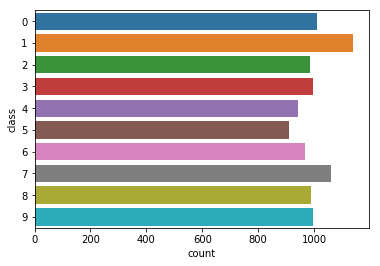

In [5]:
# plot class distriubtion
sns.countplot(data=all_df,y='class')

Let's have a look to the images after feature sub-resolution and check that our dataset is correct, i.e that the labels correspond to the image : 


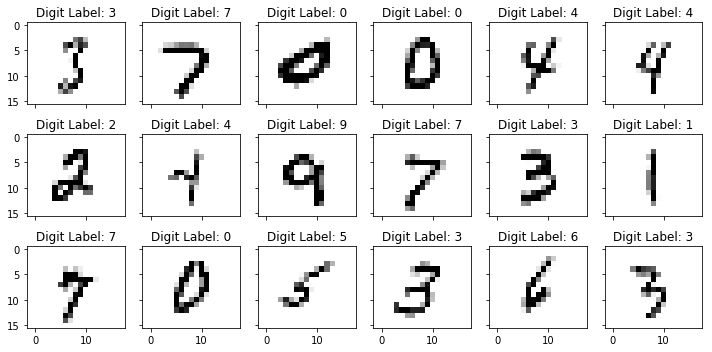

In [6]:
import random
import matplotlib.pyplot as plt
import numpy as np

number_plot_images = 18
random_indices = random.sample(range(READ_N_SAMPLES), number_plot_images)

fig, axes = plt.subplots(3,6, 
                        figsize=(10,5),
                        sharex=True, sharey=True,
                        subplot_kw=dict( aspect='equal')) 

for i in range(number_plot_images):
    
    subplot_row = i//6 
    subplot_col = i%6  
    ax = axes[subplot_row, subplot_col]
    # plot image on subplot
    plottable_image = all_df.iloc[random_indices[i],:IMG_SIZE*IMG_SIZE].values.reshape((IMG_SIZE,IMG_SIZE))
    ax.imshow(plottable_image, cmap='gray_r')
    
    ax.set_title('Digit Label: {}'.format(all_df['class'][random_indices[i]]))
    ax.set_xbound([0,IMG_SIZE])

plt.tight_layout()
plt.show()

### Train/dev/test split

When training a classifier, the data **must** be separated into different sets : at least one training set and one test set. The split must be random and uniform, which means that the class distribution must be identical in the training and test sets.

**Question:**
> * Use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to create `X_train/y_train` and `X_test/y_test`. Use 80% of the data for training and 20% for testing.
> * Train a [k-nearest neighbors](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) classififier with k=1
> * Test the k-NN with k= 1 on both the training and the test set. Print the score produced by [`clf.score()`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.score)

When evaluating a classifier, it is important to report the error rate both on the training and the classification set. These values are needed to understand what is wrong with the classifier and how to improve it.


In [8]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors

test_percent = 0.2 # YOUR CODE HERE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percent, random_state=32)# YOUR CODE HERE

# create a kNN classifier with a given k
k = 1 # YOUR CODE HERE
clf = neighbors.KNeighborsClassifier(k,n_jobs=-1)# YOUR CODE HERE

# Train the classifier on training set
clf.fit(X_train,y_train)# YOUR CODE HERE

# Predict and evaluate on train set
print ('Train accuracy:',clf.score(X_train, y_train))# YOUR CODE HERE
# Predict and evaluate on test set
_predicted = clf.predict(X_test)# YOUR CODE HERE
print ('Test accuracy:',clf.score(X_test,y_test))# YOUR CODE HERE

Train accuracy: 1.0
Test accuracy: 0.945


### Hyperparameter optimization


The main parameter of the kNN algorithm is the number of neighbors (k). The best value for this parameter depends on the classification task and has to be found by trying different values and selecting the one with the best accuracy. However, this search for the best value **must not** be done on the set used to evaluate the classifier (the test set) but on a validation set. 

**Question** : 


>  * Create three sets : train set (60%), validation set (20%) and test set (20%), using twice `train_test_split`
>  * Train a kNN classifier with different values of k and report the train/valid/test accuracy. 
>  * Select the is best value for k according to the accuracy on the dev set. Report the performance performance of the classifier on the test set for this value of k. 

   train    dev   test
1      1  0.941  0.943
3  0.966  0.933  0.936
5  0.957   0.94  0.931
7  0.952  0.933  0.928
9  0.944  0.926  0.931


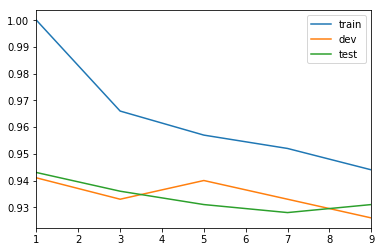

In [9]:
from IPython.display import clear_output

# Create Train/dev/test sets
# YOUR CODE HERE
# Create validation set so that train = 60% , validation = 20% and test =  20%
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=0.25)


#  list of k values to test
k_values = [1,3,5,7,9] # YOUR CODE HERE

# store the score in a dataframe
df_scores = pd.DataFrame(columns=['train','dev','test'],index=k_values)

# iterate on différent values of k
for k in k_values:
    print("k={}".format(k))
    
    # create a kNN classifier with a given k
    clf = neighbors.KNeighborsClassifier(k,n_jobs=-1) # YOUR CODE HERE
    
    # Train the classifier on training set
    clf.fit(X_train,y_train) # YOUR CODE HERE
    
    # Compute the classification score on the different sets
    for _name,_X,_y in [('train',X_train,y_train),('dev',X_dev,y_dev),('test',X_test,y_test)]:
        df_scores.at[k,_name] = float("{:.3f}".format(clf.score(_X,_y)))
        clear_output(wait=True)
        print(df_scores)
_g = df_scores.plot()


## Logistic regression

Another simple yet very effective classifier is the logisitic regression. This classifier is a version of the linear regression model adapted to classification. 

**Question** : 

> Using the MNIST Data, train a [Logistic Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier (`clf = linear_model.LogisticRegression()`) train set and  report the accuracy on dev and test sets. Compare to the best result of the kNN classifier.



In [11]:
from sklearn import linear_model
# Train a logisitic regression model 
clf = linear_model.LogisticRegression()
clf.fit(X_train,y_train)

print ("logistic regression accuracy on dev set:",clf.score(X_dev,y_dev))
print ("logistic regression accuracy on test set:",clf.score(X_test,y_test))

logistic regression accuracy on dev set: 0.924
logistic regression accuracy on test set: 0.8965


In [12]:
print ("logistic regression accuracy on train set:",clf.score(X_train,y_train))

logistic regression accuracy on train set: 0.933125


The accuracy of the classifiers depends on the size of the training set : the more data, the better accuracy. Will study the impact of the size of the training set on kNN and Logisitic Regression.

For this study, we first load 2000 training samples and we separate the data in train/test set with 80%/20% ratio. Then we train the classifier on an increasing training set corresponding to  `[1%,10%,30%,50%,70%,100%]` percents of the training set. We will always be tested on the same test set (the original one). The following Figure explains the different splits : 

<p align="center">
  <img src="https://kermorvant.github.io/ml/images/learning_curve_sets.png" width="300" >
</p>


**Question** : 


> * Report the training and test set accuracies for the Logisitic Regresstion, 1NN and kNN (k being the best value for `k` you previously found). 
> * Plot the training curves on a plot similar to : 

<p align="center">
  <img src="https://kermorvant.github.io/ml/images/training_curves.png" width="300" align="center">
</p>

You can use [pandas plot function](https://pandas.pydata.org/pandas-docs/stable/visualization.html#basic-plotting-plot).



     LogRegTrain LogRegTest 1NNTrain 1NNTest  5NNTrain 5NNTest
20             1       0.39        1  0.4075       0.8    0.29
200            1      0.725        1   0.765     0.875  0.6875
600            1     0.7875        1    0.86  0.898333    0.84
1000           1     0.7525        1  0.8725     0.919    0.88
1400    0.998571       0.81        1     0.9     0.935  0.8975
2000    0.994375      0.835        1   0.905  0.936875   0.905


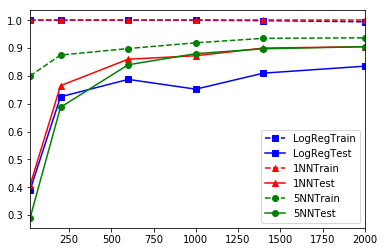

In [20]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
nb_train = 2000
print (nb_train)
SIZES = [int(nb_train*x/100.) for x in [1,10,30,50,70,100]]
df_scores = pd.DataFrame(columns=['LogRegTrain','LogRegTest','1NNTrain','1NNTest','5NNTrain','5NNTest'],index=SIZES)

clf1 = linear_model.LogisticRegression()
clf2 = neighbors.KNeighborsClassifier(1)
clf3 = neighbors.KNeighborsClassifier(5)


for sub_size in SIZES:

    X_sub = X_train.iloc[:sub_size]  
    # get the index of the selected samples dans extract the corresponding targets
    y_sub = y_train.iloc[:sub_size]
    # train the models
    clf1.fit(X_sub,y_sub)
    clf2.fit(X_sub,y_sub)
    clf3.fit(X_sub,y_sub)

    # compute accuracy on train set
    df_scores.at[sub_size,'LogRegTrain'] =  clf1.score(X_sub,y_sub)
    # compute accuracy on test set
    df_scores.at[sub_size,'LogRegTest'] =  clf1.score(X_test,y_test)
    
    
    # compute accuracy on train set
    df_scores.at[sub_size,'1NNTrain'] =  clf2.score(X_sub,y_sub)
    # compute accuracy on test set
    df_scores.at[sub_size,'1NNTest'] =  clf2.score(X_test,y_test)
    
    
    # compute accuracy on train set
    df_scores.at[sub_size,'5NNTrain'] =  clf3.score(X_sub,y_sub)
    # compute accuracy on test set
    df_scores.at[sub_size,'5NNTest'] =  clf3.score(X_test,y_test)
    clear_output(wait=True)
    print(df_scores)
styles1 = ['bs--','bs-','r^--','r^-','go--','go-']
df_scores.plot(style=styles1)

#### Pipelines

Scikit-learn has a special class for dealing with hyperparamter optimization :  [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

We can search for the best values of the hyperparameters  by defining a pipeline. 



In [15]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('clf', neighbors.KNeighborsClassifier())
    
])

parameters = {
    'clf__n_neighbors':(1,3,5,7,9)
}


Then, the GridSearchCV object will be fitted on the train set with all the possible combinaison of parameter values and evaluated on a validation set with cross validation. The train/dev spit and the cross-validation is done automatically. Progress can be monitored with greater values of the parameter verbose.

**Question** : 


>  *  reproduce the experiments on the parameter k from the previous question using GridSearchCV
>  * add the exploration of different values of the feature dimension. 

In [16]:
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import classification_report
from pprint import pprint
if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected block

    # Define the grid search to find the best parameters for both the feature extraction and the classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=2,return_train_score=True)

    # Split the dataframe with the file names in train/test
    df_train_dev, df_test, y_train_dev, y_test = train_test_split(all_df, all_df['class'], test_size=0.2)
    
    print("Performing grid search")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    
    # Run the grid search
    grid_search.fit( df_train_dev,  y_train_dev) # YOUR CODE HERE
    all_score = pd.DataFrame(grid_search.cv_results_)
    print (all_score[['params','mean_train_score','mean_test_score']])
    
    # Print all experiments results
    print("Grid scores on development set:")
    print()
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    
    # Print best experiment results
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    # predict on test with best parameters
    y_pred = grid_search.predict(df_test) # YOUR CODE HERE
    print(classification_report(y_pred, y_test)) # YOUR CODE HERE
    print()


Performing grid search
pipeline: ['clf']
parameters:
{'clf__n_neighbors': (1, 3, 5, 7, 9)}
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] clf__n_neighbors=1 ..............................................
[CV] clf__n_neighbors=1 ..............................................
[CV] clf__n_neighbors=3 ..............................................
[CV] clf__n_neighbors=1 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   7.6s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   7.5s
[CV] clf__n_neighbors=3 ..............................................
[CV] ............................... clf__n_neighbors=1, total=   7.5s
[CV] clf__n_neighbors=5 ..............................................
[CV] ............................... clf__n_neighbors=3, total=   7.5s
[CV] clf__n_neighbors=5 ............................................

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.8min finished


                    params  mean_train_score  mean_test_score
0  {'clf__n_neighbors': 1}          1.000000         0.937750
1  {'clf__n_neighbors': 3}          0.964375         0.936000
2  {'clf__n_neighbors': 5}          0.953062         0.934000
3  {'clf__n_neighbors': 7}          0.947562         0.929500
4  {'clf__n_neighbors': 9}          0.941563         0.929125
Grid scores on development set:

0.938 (+/-0.015) for {'clf__n_neighbors': 1}
0.936 (+/-0.012) for {'clf__n_neighbors': 3}
0.934 (+/-0.012) for {'clf__n_neighbors': 5}
0.929 (+/-0.016) for {'clf__n_neighbors': 7}
0.929 (+/-0.015) for {'clf__n_neighbors': 9}

Best score: 0.938
Best parameters set:
	clf__n_neighbors: 1
             precision    recall  f1-score   support

          0       0.98      0.96      0.97       194
          1       0.99      0.96      0.97       221
          2       0.95      0.98      0.96       185
          3       0.95      0.96      0.96       207
          4       0.95      0.95      0.95 

## Support Vector Machines


We will now optimize a Support Vector Machine, SVM (Séparateurs à Vaste Marge in French) classifier on the MNIST database. These classifiers usually give very good results if they are well tuned.

All the SVM classifier share a common parameter `C`: it controls how many examples are allowed to be badly classified during the optimization. For small values of C, some training example are allowed to be misclassified if the margin  (the distance between the separating line and the support vector) is large. For large values of C, the algorithm tries to minimize the number of misclassified training example, even if it lead to a small margin. The impact of the value for C is shown on the following figure : 

<p align="center">
  <img src="https://kermorvant.github.io/ml/images/svm_values_for_C.png" width="400" >
</p>
 

**Question** : 
> * add a linear SVM classifier to the pipline :  [svm.SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) with the option `kernel='linear'`
> * add the optimization of `C`  in GridSearchCV 

The RBF kernel (see the [scikit-learn kernels documentation](http://scikit-learn.org/stable/modules/svm.html#svm-kernels) has one more main parameter that must be optimized on the data :  `gamma`.

`gamma` is a parameter controlling the *spread* of the RBF kernel : if `gamma` is small, the kernel takes into account many training samples and the decision boundary is smooth. When `gamma` is large, the kernel is focused on few training examples and the decision boundary is complex. The impact of `gamma` is illustrated on the following Figures : 

- `gamma` = 1
<p align="center">
  <img src="https://kermorvant.github.io/ml/images/svc_parameters_using_rbf_kernel_17_0.png" width="300" >
</p>

- `gamma` = 100
<p align="center">
  <img src="https://kermorvant.github.io/ml/images/svc_parameters_using_rbf_kernel_21_0.png" width="300" >
</p>

Moreover, for the RBF kernel, the data must be normalizedn you can use the [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to scale to [zero mean and unit variance](https://en.wikipedia.org/wiki/Feature_scaling#Standardization).  

**Question** : 
> * add the StandardScaler as a pipeline step
> * add the RBF kernel to the GridSearch [svm.SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) 
> * add the optimization of  `gamma` and `C` with values :  `C in [0.5,2,10]` and `gamma in [0.05,0.1,0.5]`. 

You can add a different kernel with its specific parameters this way : 
<pre>
        {
         'clf__kernel': ['rbf'],
         'clf__gamma': [1e-3, ],
         'clf__C': [1,]
        },
</pre>



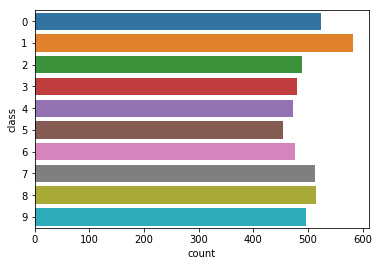

In [24]:
READ_N_SAMPLES = 5000
IMG_SIZE = 16
all_df = pd.read_csv("../data/MNIST_all_features16.csv.gz" ,nrows=READ_N_SAMPLES)
all_df.head()
# define the features and the targets
X = all_df.iloc[:,:IMG_SIZE*IMG_SIZE]
y = all_df['class']

sns.countplot(data=all_df,y='class')

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


pipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('clf', svm.SVC())
   
    
])

gamma_range = [0.0005,0.001,0.005,0.01,0.05]
C_range = [0.1,1,5,10,50]
parameters = [
        #{
        #'clf__kernel': ['linear'],
        #'clf__C': C_range
        #},
        {
         'clf__kernel': ['rbf'],
         'clf__gamma': gamma_range,
         'clf__C': C_range
        }
    
]

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=2, cv=2)

    X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.2)
    
    print (X_train_dev.shape,X_test.shape,y_train_dev.shape,y_test.shape)
    print("Performing grid search")

    grid_search.fit( X_train_dev,  y_train_dev)
    
    # Print all experiments results
    print("Grid scores on development set:")
    print()
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    
    # Print best experiment results
    print("Best score: %0.3f" % grid_search.best_score_)

    # predict on test with best parameters
    y_pred = grid_search.predict(X_test)
    print(classification_report(y_test,y_pred))
    print()


(4000, 256) (1000, 256) (4000,) (1000,)
Performing grid search
Fitting 2 folds for each of 25 candidates, totalling 50 fits
[CV] clf__C=0.1, clf__gamma=0.0005, clf__kernel=rbf ..................
[CV] clf__C=0.1, clf__gamma=0.0005, clf__kernel=rbf ..................
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................
[CV] clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf ...................
[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   9.3s
[CV] clf__C=0.1, clf__gamma=0.005, clf__kernel=rbf ...................
[CV] .... clf__C=0.1, clf__gamma=0.001, clf__kernel=rbf, total=   9.3s
[CV] clf__C=0.1, clf__gamma=0.005, clf__kernel=rbf ...................
[CV] ... clf__C=0.1, clf__gamma=0.0005, clf__kernel=rbf, total=   9.7s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] ... clf__C=0.1, clf__gamma=0.0005, clf__kernel=rbf, total=   9.8s
[CV] clf__C=0.1, clf__gamma=0.01, clf__kernel=rbf ....................
[CV] .... clf__C=0.1, cl

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min


[CV] ..... clf__C=10, clf__gamma=0.001, clf__kernel=rbf, total=   3.8s
[CV] clf__C=10, clf__gamma=0.01, clf__kernel=rbf .....................
[CV] ..... clf__C=10, clf__gamma=0.005, clf__kernel=rbf, total=   4.9s
[CV] clf__C=10, clf__gamma=0.05, clf__kernel=rbf .....................
[CV] ..... clf__C=10, clf__gamma=0.005, clf__kernel=rbf, total=   5.0s
[CV] clf__C=10, clf__gamma=0.05, clf__kernel=rbf .....................
[CV] ...... clf__C=10, clf__gamma=0.01, clf__kernel=rbf, total=   5.9s
[CV] clf__C=50, clf__gamma=0.0005, clf__kernel=rbf ...................
[CV] ...... clf__C=10, clf__gamma=0.01, clf__kernel=rbf, total=   6.0s
[CV] clf__C=50, clf__gamma=0.0005, clf__kernel=rbf ...................
[CV] .... clf__C=50, clf__gamma=0.0005, clf__kernel=rbf, total=   2.7s
[CV] clf__C=50, clf__gamma=0.001, clf__kernel=rbf ....................
[CV] .... clf__C=50, clf__gamma=0.0005, clf__kernel=rbf, total=   2.7s
[CV] clf__C=50, clf__gamma=0.001, clf__kernel=rbf ....................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


Grid scores on development set:

0.357 (+/-0.018) for {'clf__C': 0.1, 'clf__gamma': 0.0005, 'clf__kernel': 'rbf'}
0.631 (+/-0.006) for {'clf__C': 0.1, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
0.794 (+/-0.018) for {'clf__C': 0.1, 'clf__gamma': 0.005, 'clf__kernel': 'rbf'}
0.746 (+/-0.030) for {'clf__C': 0.1, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}
0.229 (+/-0.046) for {'clf__C': 0.1, 'clf__gamma': 0.05, 'clf__kernel': 'rbf'}
0.862 (+/-0.008) for {'clf__C': 1, 'clf__gamma': 0.0005, 'clf__kernel': 'rbf'}
0.885 (+/-0.018) for {'clf__C': 1, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
0.901 (+/-0.016) for {'clf__C': 1, 'clf__gamma': 0.005, 'clf__kernel': 'rbf'}
0.892 (+/-0.032) for {'clf__C': 1, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}
0.641 (+/-0.031) for {'clf__C': 1, 'clf__gamma': 0.05, 'clf__kernel': 'rbf'}
0.901 (+/-0.006) for {'clf__C': 5, 'clf__gamma': 0.0005, 'clf__kernel': 'rbf'}
0.906 (+/-0.014) for {'clf__C': 5, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
0.910 (+/-0.015) for {

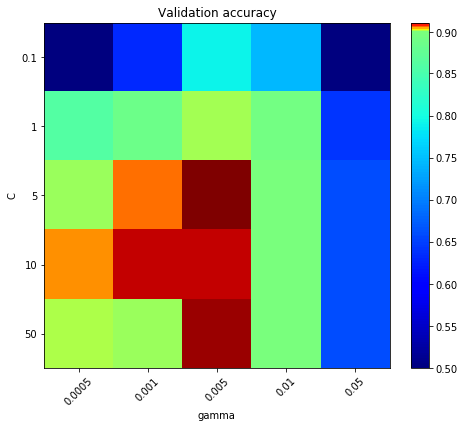

In [28]:
# Plots are from https://github.com/ksopyla/svm_mnist_digit_classification 
from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
def plot_param_space_scores(scores, C_range, gamma_range):
    
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.jet,
               norm=MidpointNormalize(vmin=0.5, midpoint=0.9))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
    plt.yticks(np.arange(len(C_range)), C_range)
    plt.title('Validation accuracy')
    plt.show()
    


scores = grid_search.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

plot_param_space_scores(scores, C_range, gamma_range)

Now that we have found the best classifier (SVM RBF) and the best hyperparameter values, we can train the final classifier on all the data and evaluate it. 

In [13]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# train on all the data
READ_N_SAMPLES = 60000
IMG_SIZE = 16
all_df = pd.read_csv("../data/MNIST_all_features16.csv.gz" ,nrows=READ_N_SAMPLES)
all_df.head()
# define the features and the targets
X = all_df.iloc[:,:IMG_SIZE*IMG_SIZE]
y = all_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
classifier = svm.SVC(gamma=0.005,C=5,verbose=True) 
classifier.fit( X_train,  y_train)

[LibSVM]

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = classifier.predict(X_test)
print(classification_report(y_pred, y_test))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99      1185
          1       0.99      0.99      0.99      1354
          2       0.98      0.93      0.96      1301
          3       0.96      0.97      0.97      1211
          4       0.98      0.97      0.98      1116
          5       0.97      0.98      0.97      1012
          6       0.98      0.99      0.98      1160
          7       0.97      0.97      0.97      1274
          8       0.97      0.97      0.97      1218
          9       0.96      0.98      0.97      1169

avg / total       0.97      0.97      0.97     12000

